In [1]:
import os
import sys
import json
from pathlib import Path
from typing import Union

sys.path.insert(0, str(Path(os.getcwd()).parent.parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from src.data_analysis.model_training import (
    get_device_helper,
    get_fashion_mnist_data_sets
)
from src.data_analysis.model_evaluation import feature_maps_viz_runner
from src.data_analysis.custom_cnn import MyFirstCNN, MySecondCNN
from src.common.file_io_helper import incriment_file

VISUALS_DIR = 'visualizations'
CUTOVER_EXPERIMENT = 43
MODEL_EXPERIMENT_FILEPATH = 'experiments/models/experiment_number_{:04d}.pth'
EXPERIMENT_FILEPATH = 'experiments/experiments.json'

In [2]:
def load_model(experiment_number: int, exp_df: pd.DataFrame) -> torch.nn.Module:
    if experiment_number > CUTOVER_EXPERIMENT:
        model = MySecondCNN()
    else:
        model = MyFirstCNN()
    
    model_dict_and_metadata = torch.load(MODEL_EXPERIMENT_FILEPATH.format(experiment_number + 1), weights_only=False)
    model_state_dict = model_dict_and_metadata["model_state_dict"]
    model_dict_and_metadata.pop("model_state_dict")
    model.load_state_dict(model_state_dict)
    return model, model_dict_and_metadata


def plot_model_results(model_metadata: Union[dict, list[dict]], experiments: list[int], savefig: bool = True):
    if not model_metadata:
        raise ValueError('No model metadata provided')

    if isinstance(model_metadata, dict):
        model_metadata = [model_metadata]
    fig = plt.figure(figsize=(12, 8), dpi=100)
    ax0 = fig.add_subplot(221)
    ax1 = fig.add_subplot(222)
    ax2 = fig.add_subplot(223)
    ax3 = fig.add_subplot(224)
    
    for experiment_no, metadata in zip(experiments, model_metadata):
        label=f'Exp No. {experiment_no} (Test Acc: {metadata["mean_test_accuracy"]:.4f})'
        ax0.plot(metadata['train_loss'], label=label, alpha=0.65)
        ax2.plot(np.array(metadata['validation_loss'])[:,0], np.array(metadata['validation_loss'])[:,1], label=label)

        ax1.plot(metadata['train_accuracy'], label=label, alpha=0.65)
        ax3.plot(np.array(metadata['validation_accuracy'])[:,0], np.array(metadata['validation_accuracy'])[:,1], label=label)

    ax0.legend()
    ax1.legend()
    ax2.legend()
    ax3.legend()

    ax0.set_title('Training Loss')
    ax1.set_title('Training Accuracy')
    ax2.set_title('Validation Loss')
    ax3.set_title('Validation Accuracy')

    plt.suptitle('Model Training Results')
    plt.tight_layout()

    if savefig:
        if not os.path.exists(VISUALS_DIR):
            os.mkdir(VISUALS_DIR)
        filename = incriment_file('model_training_results_vis.png', VISUALS_DIR)
        plt.savefig(filename)
    plt.show()


def gather_metadata(
    experiments: list[int],
    experiments_df: pd.DataFrame,
) -> tuple[list[torch.nn.Module], list[dict]]:
    model_metadata = []
    models = []
    for i in experiments:
        model, metadata = load_model(i, experiments_df)
        model_metadata.append(metadata)
        models.append(model)
    return models, model_metadata


In [5]:
with open(EXPERIMENT_FILEPATH, 'r') as file:
    records = json.load(file)
    experiment_results_df = pd.DataFrame.from_records(records)

experiment_results_df.tail()

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy
40,CNN,30,54890,0:02:40,SGD,0.100,{'momentum': 0.9},xavier_uniform,0.907617,0.017698
41,CNN,30,54890,0:02:43,Adam,0.100,"{'betas': [0.9, 0.99]}",xavier_uniform,0.892480,0.020222
42,CNN,30,54890,0:02:41,RMSprop,0.100,{'alpha': 0.9},xavier_uniform,0.829004,0.019870
43,CNN,40,54890,0:03:40,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.917285,0.016867
44,CNN,40,54890,0:03:39,Adam,0.001,"{'betas': [0.9, 0.999]}",kaiming_uniform,0.916992,0.016147


In [ ]:

experiment_results_df.loc[experiment_results_df["mean_test_accuracy"].idxmax()]

In [13]:
experiment_results_df.loc[[20]]

,model_type,num_epochs,total_num_weights,training_time,optimizer,learning_rate,optimizer_hyperparams,weight_init,mean_test_accuracy,std_test_accuracy
20,CNN,30,54890,0:02:48,Adam,0.0001,"{'betas': [0.9, 0.9]}",random_normal,0.876855,0.019433


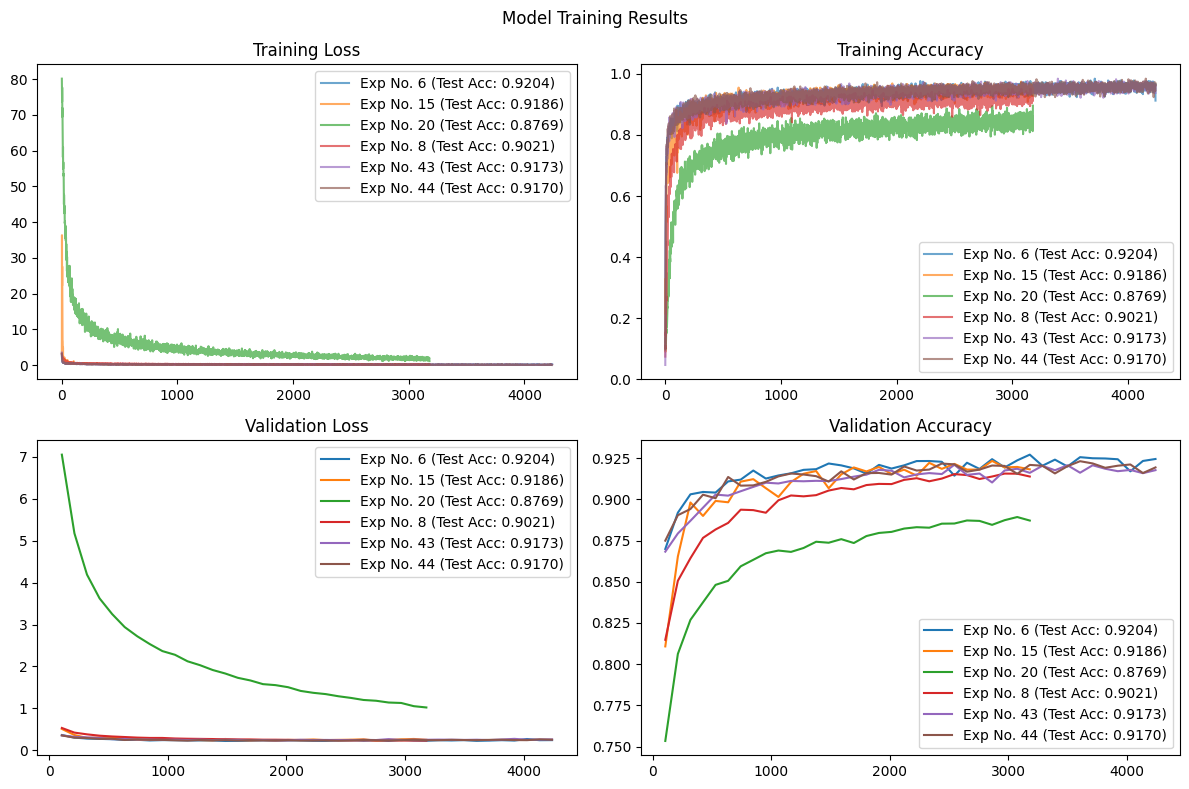

In [14]:
exps = [6, 15, 20, 8, 43, 44]

models, model_metadata_list = gather_metadata(exps, experiments_df=experiment_results_df)

plot_model_results(
    model_metadata_list,
    exps,
    savefig=False,
)

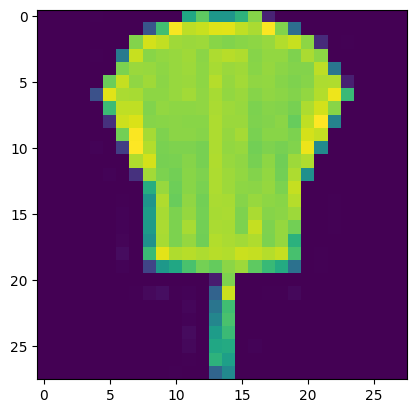

In [133]:
train_dataset, test_dataset = get_fashion_mnist_data_sets()
device = get_device_helper()

plt.imshow(train_dataset.data[56], cmap="viridis")
plt.show()

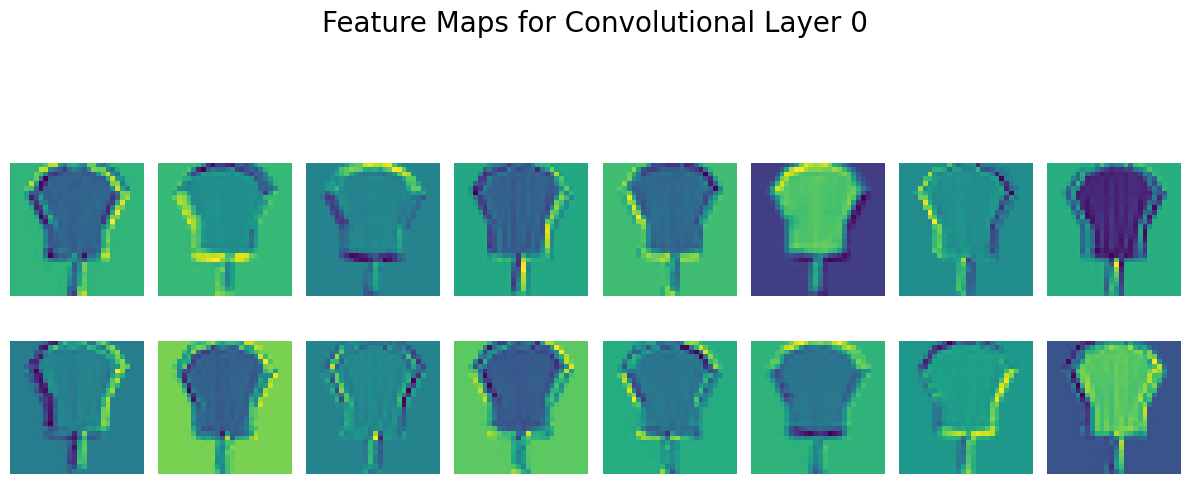

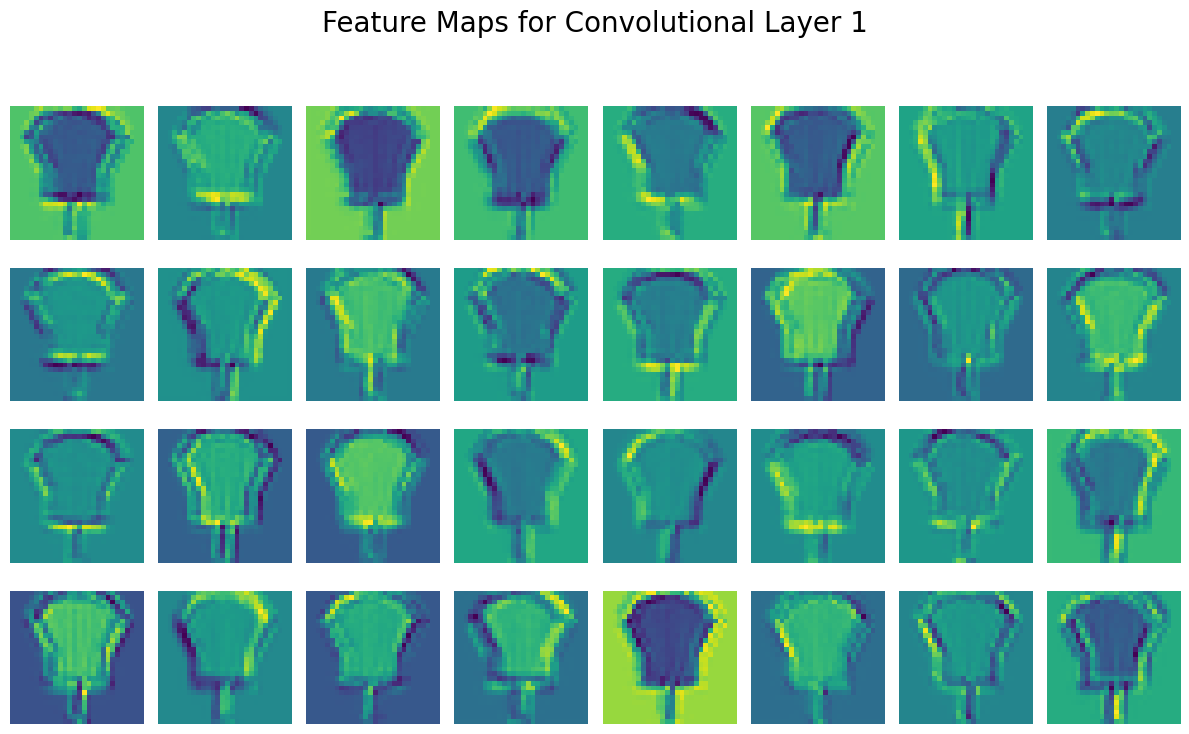

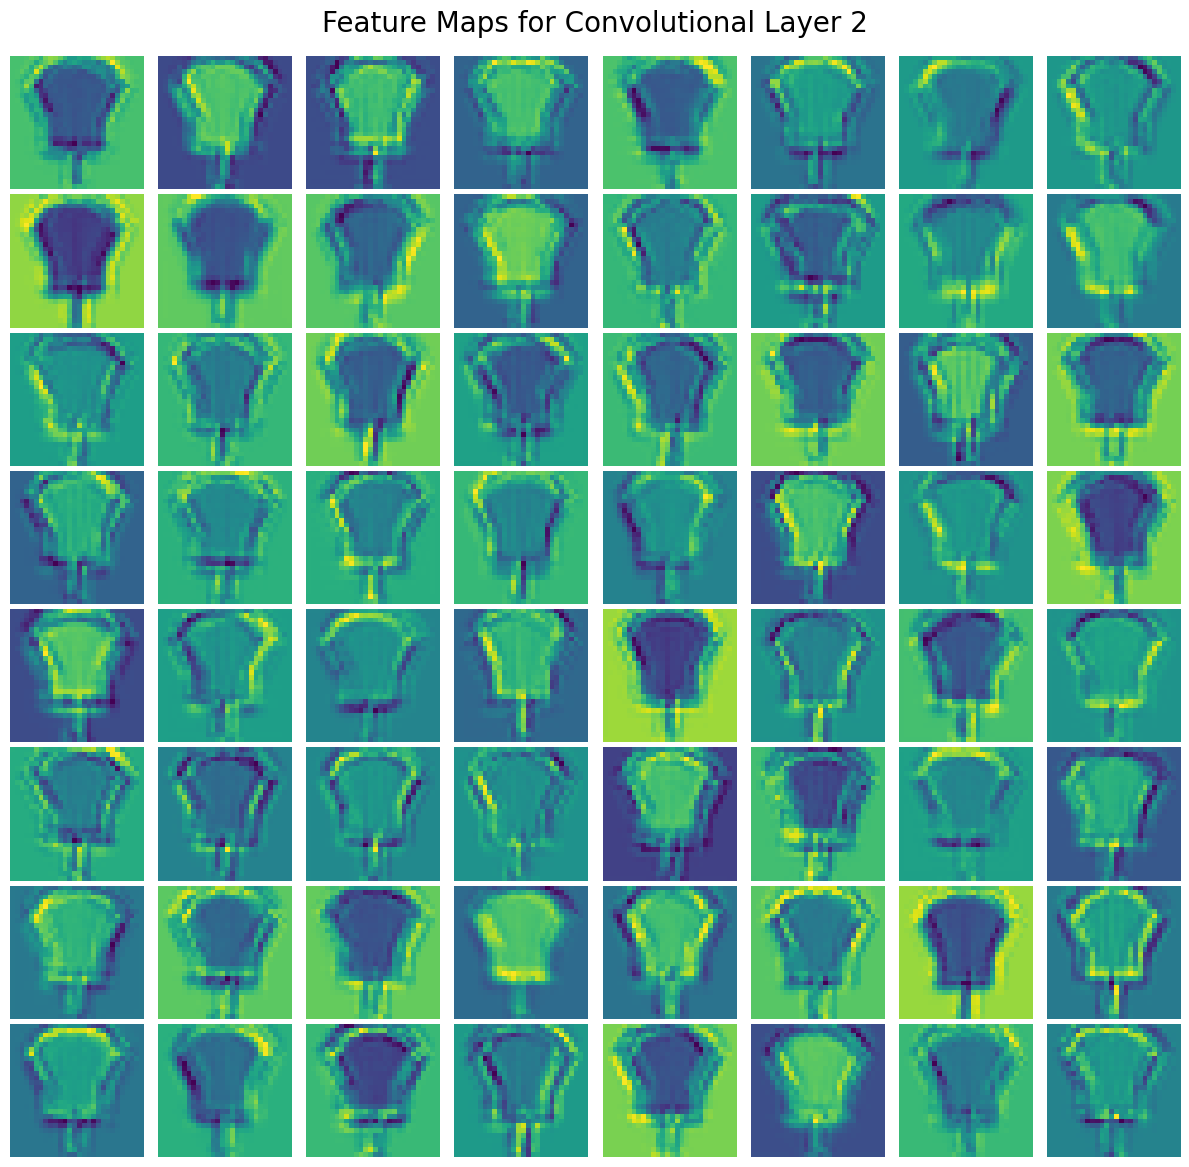

In [135]:
feature_maps_viz_runner(
    models[1],
    train_dataset.data[56],
    save_feature_maps=False,
    cmap="viridis",
)

In [136]:
# TODO: This is something for filtering experiments on certain things



# def model_arch_filter(x: pd.DataFrame, desired_arch: list[int]) -> pd.Series:
#     return x["model_architecture"] == desired_arch

# experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 512, 10],))

# no_batch_norm_rand_normal_mask = (
#     experiment_results_df["batch_normalization"]
#     & (experiment_results_df["weight_init"] == "xavier_uniform")
#     & (experiment_results_df["optimizer"] == "Adam")
#     # & (experiment_results_df["learning_rate"] == 0.01)
#     & (experiment_results_df["num_epochs"] == 30)
#     & experiment_results_df.apply(model_arch_filter, axis=1, args=([1024, 256, 10],))
# )
# no_batch_norm_rand_normal_mask.sum()

# experiment_results_df[no_batch_norm_rand_normal_mask]

In [138]:
# exps = experiment_results_df[no_batch_norm_rand_normal_mask].index.tolist()
# model_metadata_list = gather_metadata(
#     exps
# )

# plot_model_results(
#     model_metadata_list,
#     exps,
#     savefig=True,
# )

In [137]:
# experiment_subset_mask = (
#     (experiment_results_df["num_epochs"] == 30) &
#     (experiment_results_df["batch_normalization"] == True) &
#     (experiment_results_df["model_architecture"].apply(lambda x: tuple(x)) == (1024, 256, 10)) &
#     (experiment_results_df["optimizer"] == "Adam")
# )

# experiment_results_df[experiment_subset_mask]